In [1]:

import torch
import os

import datetime
import time

import forest

# from forest.filtering_defenses import get_defense
from forest.utils import write, set_random_seed
from forest.consts import BENCHMARK, NUM_CLASSES
torch.backends.cudnn.benchmark = BENCHMARK

# Parse input arguments
args = forest.options().parse_args()
args.dataset = os.path.join('datasets', args.dataset)
args.exp_name = 'testing'
args.poisonkey = '6-1'
args.attackiter = 750
args.alpha = 0.05
args.trigger = 'sunglasses'
args.devices = '0,1'
args.vruns = 1
args.poison_selection_strategy = 'max_gradient'
args.visreg == 'l1'
args.model_seed = 6832529
args.poison_seed = 6832529
args.load_trained_model = True

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=args.devices

if args.system_seed != None:
    set_random_seed(args.system_seed)

if args.exp_name is None:
    exp_num = len(os.listdir(os.path.join(os.getcwd(), 'outputs'))) + 1
    args.exp_name = f'exp_{exp_num}'

args.output = f'outputs/{args.exp_name}/{args.recipe}/{args.scenario}/{args.trigger}/{args.net[0].upper()}/{args.poisonkey}_{args.scenario}_{args.trigger}_{args.alpha}_{args.beta}_{args.attackoptim}_{args.attackiter}.txt'

os.makedirs(os.path.dirname(args.output), exist_ok=True)
open(args.output, 'w').close() # Clear the output files

torch.cuda.empty_cache()
if args.deterministic:
    forest.utils.set_deterministic()

setup = forest.utils.system_startup(args) # Set up device and torch data type

model = forest.Victim(args, num_classes=NUM_CLASSES, setup=setup) # Initialize model and loss_fn
data = forest.Kettle(args, model.defs.batch_size, model.defs.augmentations,
                        model.defs.mixing_method, setup=setup) # Set up trainloader, validloader, poisonloader, poison_ids, trainset/poisonset/source_testset
witch = forest.Witch(args, setup=setup)

start_time = time.time()
if args.skip_clean_training:
    write('Skipping clean training...', args.output)
else:
    model.train(data, max_epoch=10)
    
# train_time = time.time()
# print("Train time: ", str(datetime.timedelta(seconds=train_time - start_time)))

# if args.recipe != 'naive' and witch.args.backdoor_finetuning:
#     witch.backdoor_finetuning(model, data, lr=0.000005, num_epoch=25)
#     if witch.args.load_feature_repr:
#         model.save_feature_representation()
            
# # Select poisons based on maximum gradient norm
# data.select_poisons(model)

# # Print data status
# data.print_status()
    
# if args.recipe != 'naive':
#     poison_delta = witch.brew(model, data)
# else:
#     poison_delta = None

# craft_time = time.time()
# model.validate(data, poison_delta, val_max_epoch=40)
# print("Craft time: ", str(datetime.timedelta(seconds=craft_time - train_time)))

Tuesday, 05. March 2024 06:26AM
------------------ Currently evaluating gradient-matching ------------------
Namespace(EPSILON=1e-07, ablation=1.0, alpha=0.05, atk_succ_threshold=99.0, attack_mode='all2one', attackiter=250, attackoptim='signAdam', backdoor_finetuning=False, batch_size=64, beta=0.0, cache_dataset=False, centreg=0, checkpoints='../../checkpoints/', clean_budget=0.2, clean_grad=False, constrain_perturbation=False, cost_multiplier=2, data_aug='default', dataset='datasets/Facial_recognition_crop_partial', defend_features_only=False, defense='', defense_set='testset', defense_sources=None, defense_steps=None, defense_strength=None, defense_type=None, deterministic=False, devices='0,1', digital_trigger=False, digital_trigger_path='digital_triggers', disable_adaptive_attack=True, dryrun=False, early_stop=True, early_stop_patience=10, early_stop_threshold=99.0, ensemble=1, eps=8, exp_name='testing', f='/home/ubuntu/.local/share/jupyter/runtime/kernel-v2-400864zEFCuLX91f6m.json'

In [2]:
# Original data sampling and poisoning
data.select_poisons(model) 
poison_delta = witch.brew(model, data)
model.validate(data, poison_delta, val_max_epoch=10)

/home/ubuntu/21thinh.dd/Clean-label-Physical-Backdoor-Attack/forest/victims/victim_single.py:165: UserWarning: Batch size changed to 60 to fit source train size
  warnings.warn(f'Batch size changed to {batch_size} to fit source train size')


ResNet50 model initialized with random key 2699716844.
Hyperparameters(name='conservative', epochs=40, batch_size=64, optimizer='SGD', lr=0.001, scheduler='linear', weight_decay=0.0005, augmentations='default', privacy={'clip': None, 'noise': None, 'distribution': None}, validate=10, novel_defense=None, mixing_method=None, adaptive_attack=True, defend_features_only=False)


In [2]:
import copy
import torchvision.transforms.v2 as transforms
from forest.data.datasets import data_transforms
from forest.data import datasets

class ModifyTarget:
    def __init__(self, y_target):
        self.y_target = y_target

    def __call__(self, y_target):
        return self.y_target
    

def backdoor_finetuning(model, kettle, num_epoch=10, lr=0.0001):
    """Finetuning on triggerset of both target class and source class"""    
    write("\nBegin backdoor finetuning ...", args.output)

    source_class = kettle.poison_setup['source_class'][0]
    target_class = kettle.poison_setup['target_class']
    finetune_idcs = kettle.triggerset_dist[source_class]
        
    dirty_triggerset = copy.deepcopy(kettle.triggerset)
    dirty_triggerset.target_transform = transforms.Compose([ModifyTarget(target_class)])
    
    finetune_set = datasets.Subset(dirty_triggerset, finetune_idcs, transform=copy.deepcopy(data_transforms['train']))
    finetune_loader = torch.utils.data.DataLoader(finetune_set, batch_size=16, shuffle=True, num_workers=3)
    
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoch, eta_min=lr*0.01)
    for epoch in range(num_epoch):
        total_loss, total_corrects, totals = 0, 0, 0
        for (data, target, idx) in finetune_loader:
            optimizer.zero_grad()
            data, target = data.to(setup['device']), target.to(setup['device'])
            output = model(data)
            
            predictions = torch.argmax(output.data, dim=1)
            correct_preds = (predictions == target).sum().item()
            
            loss = loss_fn(output, target)
        
            loss.backward()
            
            total_loss += loss.item() * data.shape[0] 
            total_corrects += correct_preds
            totals += data.shape[0]
            
            optimizer.step()
            scheduler.step()
        
        total_loss /= totals
        total_corrects /= totals
        write(f"Epoch {epoch} Loss: {total_loss} | Accuracy: {total_corrects}", args.output)
        if total_loss <= 1e-3: 
            write("\n", args.output)
            break

In [3]:
import copy
backdoored_model = copy.deepcopy(model.model)
backdoor_finetuning(backdoored_model, data, num_epoch=10, lr=0.0001)

In [21]:
import numpy as np
from torch.nn import ReLU
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_out[0]
        # Register hook to the first layer
        self.model.avgpool.register_full_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

            # Loop through layers, hook up ReLUs
            for pos, module in self.model.avgpool._modules.items():
                if isinstance(module, ReLU):
                    module.register_backward_hook(relu_backward_hook_function)
                    module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        one_hot_output = one_hot_output.to(setup['device'])
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.cpu().data.numpy()[0]
        return gradients_as_arr

In [24]:
from math import ceil
from forest.data.datasets import Subset
def get_backdoored_gradients(backdoored_model, data):
    backdoored_model.eval()
    GBP = GuidedBackprop(backdoored_model)

    target_label = data.poison_setup['target_class']
    source_class = data.poison_setup['source_class'][0]
    backdoored_gradients = None
    for num, sample in enumerate(data.source_testset[source_class]):
        img, label, idx = sample
        img = img.unsqueeze(0)
        img = img.to(setup['device'])
        gradient = GBP.generate_gradients(img, target_label)
        print(gradient)
        if num == 0:
            backdoored_gradients = gradient
        else:
            backdoored_gradients += gradient

    backdoored_gradients /= len(data.source_testset)
    return backdoored_gradients

def select_poisons(data, clean_model, backdoored_gradients):
    """Select poisons based on maximum gradient norm"""
    clean_model.eval()
    GBP = GuidedBackprop(clean_model)
    poison_class = data.poison_setup['poison_class']
    
    # Collect images and labels
    images, labels, poison_target_ids = [], [], []
    for idx in data.trainset_distribution[poison_class]:
        images.append(data.trainset[idx][0])
        labels.append(data.trainset[idx][1])
        poison_target_ids.append(idx)
        
    images = torch.stack(images, dim=0).to(**setup)
    labels = torch.tensor(labels).to(device=setup['device'], dtype=torch.long)
    poison_target_ids = torch.tensor(poison_target_ids, dtype=torch.long)
    sim_coeffs = []

    for image, label in zip(images, labels):
        img = image.to(**setup)
        gradient = GBP.generate_gradients(img.unsqueeze(0), label.item())
        print(gradient)
        similarity = np.dot(gradient.flatten(), backdoored_gradients.flatten())
        print(similarity)
        sim_coeffs.append(similarity)  

    data.poison_num = ceil(np.ceil(data.args.alpha * len(data.trainset_distribution[poison_class])))
    indices = [i[0] for i in sorted(enumerate(sim_coeffs), key=lambda x:x[1])][-data.poison_num:]
    
    # Select poisons with maximum gradient norm
    poison_target_ids = poison_target_ids[indices]
    write('Selecting {} clean samples from class {} with maximum similarity for poisoning'.format(len(poison_target_ids), poison_class), data.args.output)
    
    data.poison_target_ids = poison_target_ids.tolist()
    data.poison_target_ids.sort()
    data.poisonset = Subset(data.trainset, indices=copy.deepcopy(data.poison_target_ids)) # Deep copy to prevent overwrite
    if data.args.pbatch == None:
        data.poison_batch_size = len(data.poisonset)
    else:
        data.poison_batch_size = data.args.pbatch
    
    if data.poisonset is None: raise ValueError('Poisonset is not defined!')
    data.poisonloader = torch.utils.data.DataLoader(data.poisonset, batch_size=data.poison_batch_size, shuffle=True,
                    drop_last=False, num_workers=data.num_workers, pin_memory=True)
    
    data.poison_lookup = dict(zip(data.poison_target_ids, range(data.poison_num)))

In [16]:
for example in data.poisonloader:
    inputs, labels, ids = example
    # Check adversarial pattern ids
    print(int(ids[0]))
    lookup = data.poison_lookup.get(int(ids[0]))
    
    print(lookup)
    break

572
12


In [17]:
print(data.poison_lookup)

{355: 0, 423: 1, 424: 2, 425: 3, 426: 4, 436: 5, 437: 6, 445: 7, 481: 8, 490: 9, 493: 10, 539: 11, 572: 12}


In [18]:
data.poison_target_ids

[355, 423, 424, 425, 426, 436, 437, 445, 481, 490, 493, 539, 572]

In [19]:
ids[0]

tensor(572)

tensor([[2.4640e-07, 1.0000e+00, 2.3226e-09, 7.5879e-09, 4.7608e-09, 1.1020e-08,
         4.8926e-09, 5.9323e-08, 2.4867e-08, 1.1456e-08]], device='cuda:0')


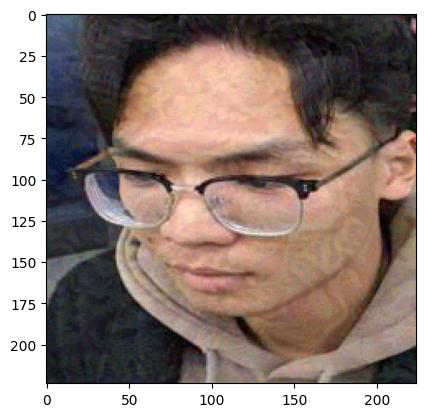

In [20]:
# Check model prediction on poisoned samples
net = model.model
net.eval()
softmax = torch.nn.Softmax(dim=1)

(img, target, idx) = data.poisonset[0]
poison_slice = data.poison_lookup.get(idx)
img_poison = (img + poison_delta[poison_slice]).to(**setup)
with torch.no_grad():
    print(softmax(net(img_poison.unsqueeze(0))))
    
import matplotlib.pyplot as plt
plt.imshow(img_poison.permute(1,2,0).cpu().numpy())

In [21]:
import numpy as np
from scipy.spatial import distance

def cosine_cluster_distances(point, cluster):

    cluster_mean = np.mean(cluster, axis=0)

    # Cosine distance to mean
    distance = 1 - np.dot(point, cluster_mean) / (np.linalg.norm(point) * np.linalg.norm(cluster_mean))
    return distance

In [22]:
from forest.victims.models import bypass_last_layer
featract, classifier = bypass_last_layer(net)

featract.eval()

with torch.no_grad():
    target_class = data.poison_setup['target_class']
    target_class_idcs = data.trainset_distribution[target_class]
    untrigger_target_poi = []
    for idx in target_class_idcs:
        img, _, _ = data.trainset[idx]
        img = img.to(**setup)
        untrigger_target_poi.append(featract(img.unsqueeze(0)).detach().cpu().numpy())
    
    source_class = data.source_class[0]
    trigger_source_poi = []
    for (img, target, idx) in data.source_testset[source_class]:
        img = img.to(**setup)
        trigger_source_poi.append(featract(img.unsqueeze(0)).detach().cpu().numpy())
        
    source_class_idcs = data.trainset_distribution[source_class]
    untrigger_source_poi = []
    for idx in source_class_idcs:
        img, _, _ = data.trainset[idx]
        img = img.to(**setup)
        untrigger_source_poi.append(featract(img.unsqueeze(0)).detach().cpu().numpy())

In [23]:
import numpy as np

trigger_source_poi = np.asarray(trigger_source_poi).squeeze()
untrigger_target_poi = np.asarray(untrigger_target_poi).squeeze()
untrigger_source_poi = np.asarray(untrigger_source_poi).squeeze()

In [24]:
with torch.no_grad():
    feat_img_poison = featract(img_poison.unsqueeze(0))

In [25]:
print(cosine_cluster_distances(feat_img_poison.cpu().numpy(), trigger_source_poi))
print(cosine_cluster_distances(feat_img_poison.cpu().numpy(), untrigger_source_poi))
print(cosine_cluster_distances(feat_img_poison.cpu().numpy(), untrigger_target_poi))

[0.5287112]
[0.6338819]
[0.11822701]
